In [4]:
# Garante que bibliotecas graficas estao instaladas
%pip install matplotlib==3.9.2 -q
%pip install networkx==3.2.1 -q

# Importa para utilizacao
import matplotlib.pyplot as plt
import networkx as nx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
class AlgoritmoAlpha:

    log: list[str]

    def __init__(self) -> None:
        pass
    
    @staticmethod
    def _get_nodes(log):
        nodes = [_ for _ in ''.join([trace for trace in log])]
        nodes = list(set(nodes))
        nodes.sort()
        return nodes
    
    @staticmethod
    def _get_inputs(log):
        inputs = [trace[0] for trace in log]
        inputs = list(set(inputs))
        inputs.sort()
        return inputs
    
    @staticmethod
    def _get_outputs(log):
        outputs = [trace[-1] for trace in log]
        outputs = list(set(outputs))
        outputs.sort()
        return outputs

    @staticmethod
    def _get_edges(log):
        edges = [
                (trace[index - 1], trace[index]) 
                for trace in log 
                for index, _ in enumerate(trace) 
                if (index - 1) >= 0
                ]
        edges = list(set(edges))
        edges.sort()
        return edges

    @staticmethod
    def _get_relationship_matrix(nodes, edges):
        relations = []
        for i in nodes:
            row = []
            for j in nodes:
                if i == j:
                    rel = '#' 
                elif (i, j) in edges and (j, i) not in edges:
                    rel = '>'
                elif (i, j) not in edges and (j, i) in edges:
                    rel = '<'
                elif (i, j) in edges and (j, i) in edges:
                    rel = '|'
                else:
                    rel = '#'
                row.append(rel)
            relations.append(row)
        return relations
    
    @staticmethod
    def _transpose_matrix(matrix):
        return [*zip(*matrix)]
    
    @staticmethod
    def _get_regular_cases(nodes, relationship_matrix):
        regular_cases = [
                        ([iName], [jName]) 
                        for i, iName in enumerate(nodes) 
                        for j, jName in enumerate(nodes) 
                        if relationship_matrix[i][j] == '>'
                        ]
        return regular_cases
    
    @staticmethod
    def _get_more_than_one_origin(nodes, relationship_matrix_T):
        more_than_one_origin = [

                                    (
                                        [
                                            jName 
                                            for j, jName in enumerate(nodes) 
                                            if relationship_matrix_T[i][j] == '>'
                                        ]
                                        , [iName]
                                      ) 
                                    for i, iName in enumerate(nodes) 
                                    if len(
                                        [
                                            j 
                                            for j, _ in enumerate(nodes) 
                                            if relationship_matrix_T[i][j] == '>'
                                        ]
                                    ) > 1

                                ]
        
        return more_than_one_origin
    
    @staticmethod
    def _get_more_than_one_destination(nodes, relationship_matrix):
        more_than_one_destinations = [
                                        (
                                            [iName], 
                                            [
                                                jName 
                                                for j, jName in enumerate(nodes) 
                                                if relationship_matrix[i][j] == '>'
                                            ]
                                        ) 
                                        for i, iName in enumerate(nodes)
                                        if len(
                                            [
                                                j 
                                                for j, _ in enumerate(nodes) 
                                                if relationship_matrix[i][j] == '>'
                                            ]
                                        ) > 1
                                    ]
        return more_than_one_destinations
    
    @staticmethod
    def _remove_parallel_origin(more_than_one_origin, log):
        tmp = more_than_one_origin.copy()
        for node in tmp:
            candidate = False
            for trace in log:
                if ''.join([_ for _ in node[0]]) in trace \
                and ''.join([_ for _ in node[1]]) in trace:
                    candidate = True
            if candidate:
                tmp.remove(node)
        return tmp
    
    @staticmethod
    def _remove_parallel_destinations(more_than_one_destinations, log):
        tmp = more_than_one_destinations.copy()
        for node in tmp:
            candidate = False
            for trace in log:
                if ''.join([_ for _ in node[0]]) in trace \
                and ''.join([_ for _ in node[1]]) in trace:
                    candidate = True
            if candidate:
                tmp.remove(node)
        return tmp
    
    @staticmethod
    def _get_raw_connections(regular_cases, 
                             more_than_one_origin, 
                             more_than_one_destinations):
        raw_connections = []
        raw_connections.extend(regular_cases)
        raw_connections.extend(more_than_one_origin)
        raw_connections.extend(more_than_one_destinations)
        return raw_connections

    @staticmethod
    def _get_connections(raw_connections, 
                         more_than_one_origin, 
                         more_than_one_destinations):
        
        connections = []
        connections.extend(more_than_one_origin)
        connections.extend(more_than_one_destinations)

        # Append only cases that arent in 
        #  more_than_one_origin
        #  and  more_than_one_destinations
        for raw in raw_connections:
            candidate = True
            for con in connections:    
                if set(raw[0]).issubset(con[0]) \
                and set(raw[1]).issubset(con[1]):
                    candidate = False
            if candidate:
                connections.append(raw)

        return connections
    
    def _create_petri_net(self):
        

        petri_net = nx.DiGraph()

        # Add special places for the input and output
        petri_net.add_node('i_input', shape='circle', label='I')
        for input in self.inputs:
            petri_net.add_edge('i_input', input)

        petri_net.add_node('i_output', shape='circle', label='O')
        for output in self.outputs:
            petri_net.add_edge(output, 'i_output')

        petri_net.add_nodes_from(['p' + str(i) for i, _ in enumerate(self.edges)], shape='circle')
        petri_net.add_nodes_from(self.nodes, shape='rectangle')

        for node in self.nodes:
            for i, edge in self.edges:                
                if node in edge[0]:
                    petri_net.add_edge(node, 'p' + str(i))
                if node in edge[1]:
                    petri_net.add_edge('p' + str(i), node)
        
        self.petri_net = petri_net
    
    def fit(self, log):
        
        self.log = log

        nodes = self._get_nodes(self.log)
        inputs = self._get_inputs(self.log)
        outputs = self._get_outputs(self.log)
        edges = self._get_edges(self.log)
        
        relationship_matrix = self._get_relationship_matrix(nodes, edges)
        relationship_matrix_T = self._transpose_matrix(relationship_matrix)

        regular_cases = self._get_regular_cases(nodes, relationship_matrix)
        
        more_than_one_origin = self._get_more_than_one_origin(nodes, relationship_matrix_T)
        more_than_one_origin = self._remove_parallel_origin(more_than_one_origin, log)

        more_than_one_destination = self._get_more_than_one_destination(nodes, relationship_matrix)
        more_than_one_destination = self._remove_parallel_destinations(more_than_one_destination, log)

        raw_connections = self._get_raw_connections(regular_cases, more_than_one_origin, more_than_one_destination)
        connections = self._get_connections(raw_connections, more_than_one_origin, more_than_one_destination)

        self.connections = connections
        self.inputs = inputs
        self.outputs = outputs
        self.edges = edges
        self.nodes = nodes

        self._create_petri_net()

        pass

    def plot(self):
        pos = nx.spring_layout(self.petri_net, seed=42)
        nx.draw(self.petri_net, pos, with_labels=True, node_size=2000, font_size=10)

        plt.title("Petri Net from Alpha Algorithm")
        plt.show()

    def summary(self):
        
        n = 100

        print('=' * n)
        print(' Algoritmo Alpha')
        print('=' * n)

        print(f' Inputs: ')
        print(f' - {self.inputs}')

        print(f' Events:')
        print(f' - {self.nodes}')
        
        print(f' Places:')
        for _ in self.connections:
            print(f' - {_}')

        print(f' Outputs:')
        print(f' - {self.outputs}')

        print(' Primeiras linhas do log: ')
        i = 1
        for _ in self.log:
            print(f' - {_}')
            i += 1
            if i > 10:
                print(f'  ... (+ {len(self.log) - i} observações)')
                break

        print('-' * n)
        print(' By Miguel Zanchettin')
        print('=' * n)

        pass


SyntaxError: invalid syntax (4226232092.py, line 193)

In [35]:

# Log do ultimo exemplo 
log = []
log.extend(['ABEF' for _ in range(2)])
log.extend(['ABECDBF' for _ in range(3)])
log.extend(['ABCEDBF' for _ in range(2)]) 
log.extend(['ABCDEBF' for _ in range(4)]) 
log.extend(['AEBCDBF' for _ in range(3)]) 

alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()

TypeError: unhashable type: 'list'

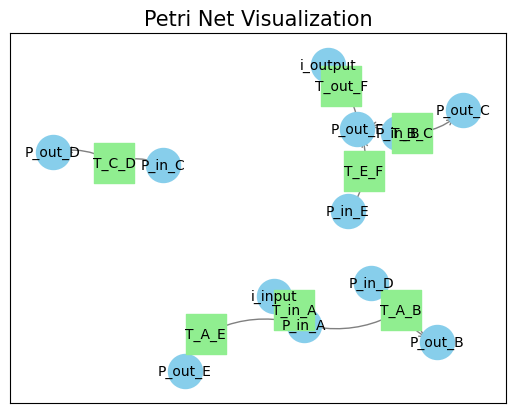

In [28]:
alpha.plot()


### Exercício 01 

Considere o seguinte log de eventos. Utilize o algoritmo $\alpha$ para descobrir o modelo correspondente em rede de Petri.

W = ABDEHJ, ABEDHJ, ABEDHGCFJ, ABEDHGBDEHJ, ACFJ, ACFGCFJ.

In [24]:
W = ['ABDEHJ', 'ABEDHJ', 'ABEDHGCFJ', 'ABEDHGBDEHJ', 'ACFJ', 'ACFGCFJ']

alpha = AlgoritmoAlpha()
alpha.fit(W)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['A']
 Nós:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J']
 Conexões:
 - (['A', 'G'], ['B'])
 - (['A', 'G'], ['C'])
 - (['F', 'H'], ['G'])
 - (['F', 'H'], ['J'])
 - (['A'], ['B', 'C'])
 - (['F'], ['G', 'J'])
 - (['G'], ['B', 'C'])
 - (['H'], ['G', 'J'])
 - (['B'], ['D'])
 - (['B'], ['E'])
 - (['C'], ['F'])
 - (['D'], ['H'])
 - (['E'], ['H'])
 Outputs:
 - ['J']
 Primeiras linhas do log: 
 - ABDEHJ
 - ABEDHJ
 - ABEDHGCFJ
 - ABEDHGBDEHJ
 - ACFJ
 - ACFGCFJ
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


/tmp/ipykernel_68435/906096427.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


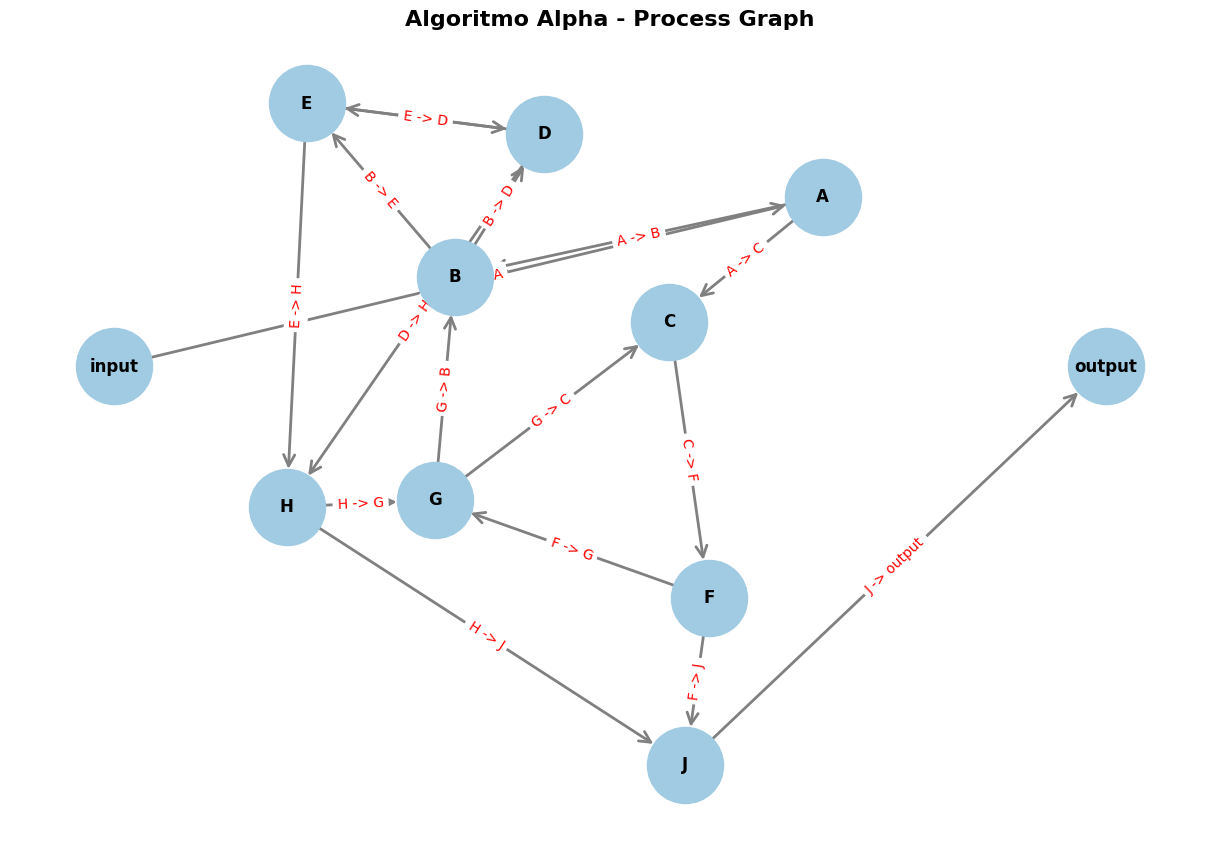

In [25]:
alpha.plot()



### Exercício 02
Considere a rede de Petri a seguir:

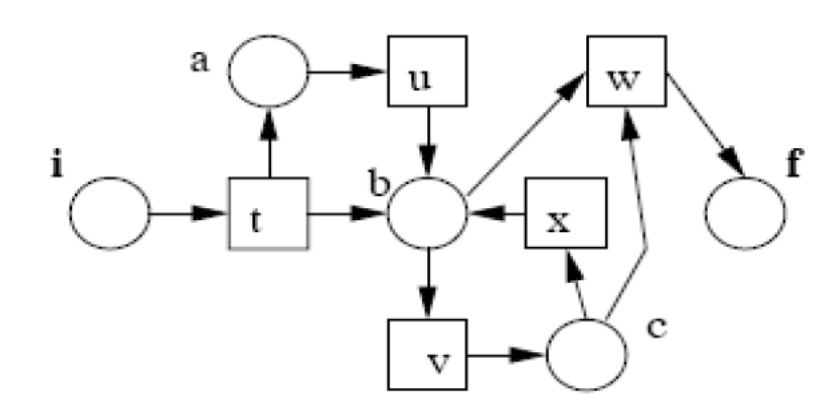

#### i. Obtenha o log de eventos completo para esta rede.


In [26]:

log = [
    'tuvxw',
    'tuw', 
    'tvxw', 
    'tvw', 
]

alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['t']
 Nós:
 - ['t', 'u', 'v', 'w', 'x']
 Conexões:
 - (['u', 'v', 'x'], ['w'])
 - (['u'], ['v', 'w'])
 - (['v'], ['w', 'x'])
 - (['t'], ['u'])
 - (['t'], ['v'])
 Outputs:
 - ['w']
 Primeiras linhas do log: 
 - tuvxw
 - tuw
 - tvxw
 - tvw
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


/tmp/ipykernel_68435/906096427.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


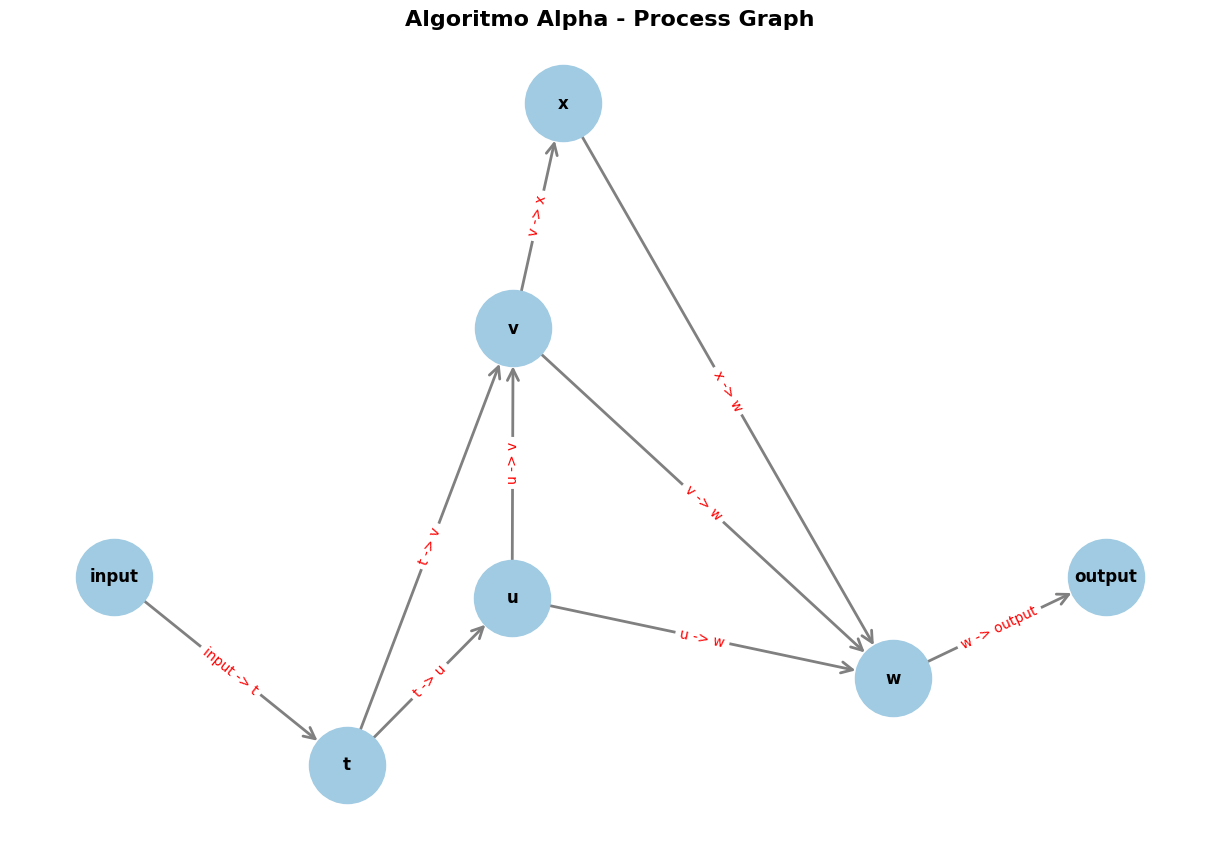

In [27]:
alpha.plot()

#### ii. Utilize o algoritmo $\alpha$ para reconstruir a rede.

### Exercício 03

O seguinte log de eventos foi obtido de um sistema de informação: 

- D A G F B C

- D A H F B I A G F B C

- E A F H B I A F H B C

- E A F G B C 

- E A H F B C

#### i. Utilize o algoritmo $\alpha$ para descobrir o modelo correspondente em rede de Petri.

In [28]:
log = [
    'DAGFBC',
    'DAHFBIAGFBC',
    'EAFHBIAFHBC',
    'EAFGBC',
    'EAHFBC'
]


alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['D', 'E']
 Nós:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
 Conexões:
 - (['D', 'E', 'I'], ['A'])
 - (['F', 'G', 'H'], ['B'])
 - (['A'], ['F', 'G', 'H'])
 - (['B'], ['C', 'I'])
 Outputs:
 - ['C']
 Primeiras linhas do log: 
 - DAGFBC
 - DAHFBIAGFBC
 - EAFHBIAFHBC
 - EAFGBC
 - EAHFBC
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


/tmp/ipykernel_68435/906096427.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


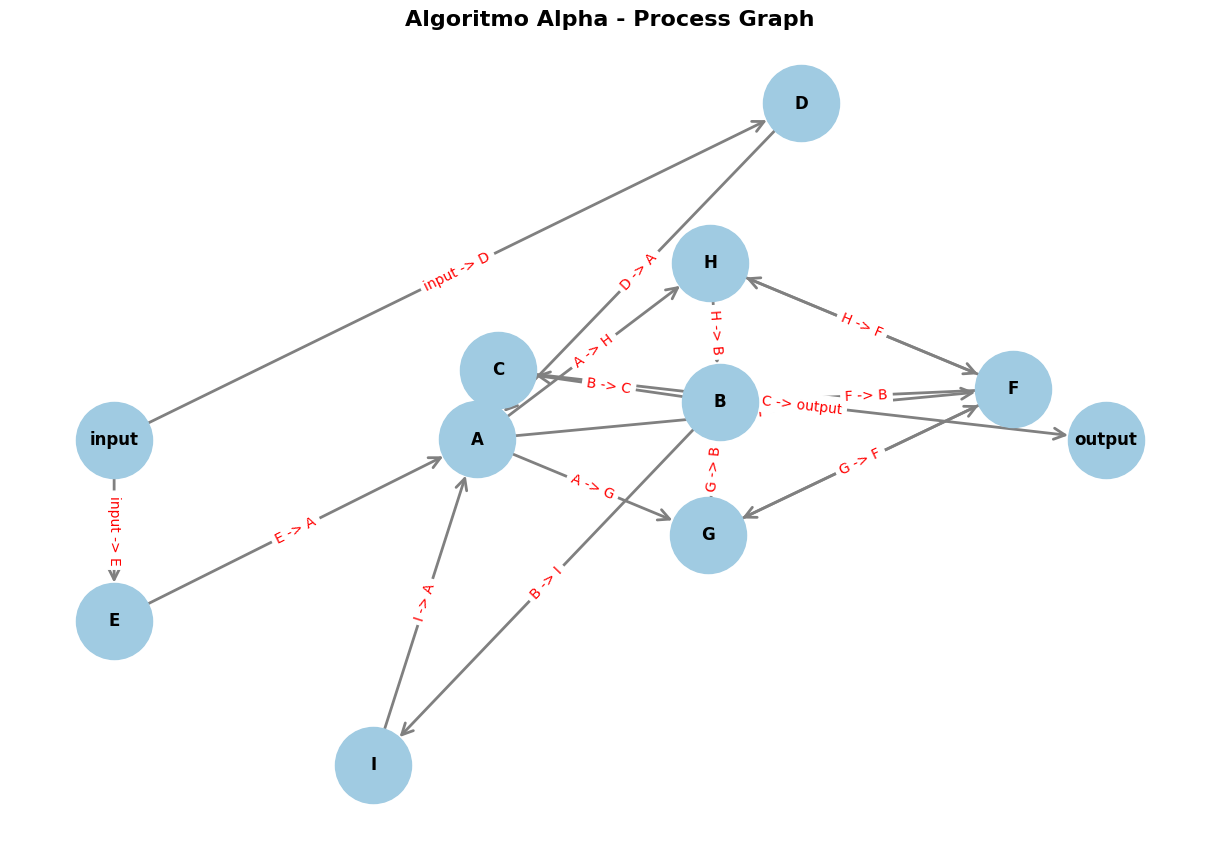

In [29]:
alpha.plot()

Considere que a atividade H é invisível, ou seja, ela não é registrada no log. 

Utilize novamente o algoritmo $\alpha$ para verificar se é possível descobrir o modelo. 

Explique o resultado.

In [30]:
log = [
    'DAGFBC',
    'DAFBIAGFBC',
    'EAFBIAFBC',
    'EAFGBC',
    'EAFBC'
]


alpha = AlgoritmoAlpha()
alpha.fit(log)
alpha.summary()


 Algoritmo Alpha
 Inputs: 
 - ['D', 'E']
 Nós:
 - ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I']
 Conexões:
 - (['D', 'E', 'I'], ['A'])
 - (['B'], ['C', 'I'])
 - (['A'], ['F'])
 - (['A'], ['G'])
 - (['F'], ['B'])
 - (['G'], ['B'])
 Outputs:
 - ['C']
 Primeiras linhas do log: 
 - DAGFBC
 - DAFBIAGFBC
 - EAFBIAFBC
 - EAFGBC
 - EAFBC
----------------------------------------------------------------------------------------------------
 By Miguel Zanchettin


/tmp/ipykernel_68435/906096427.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


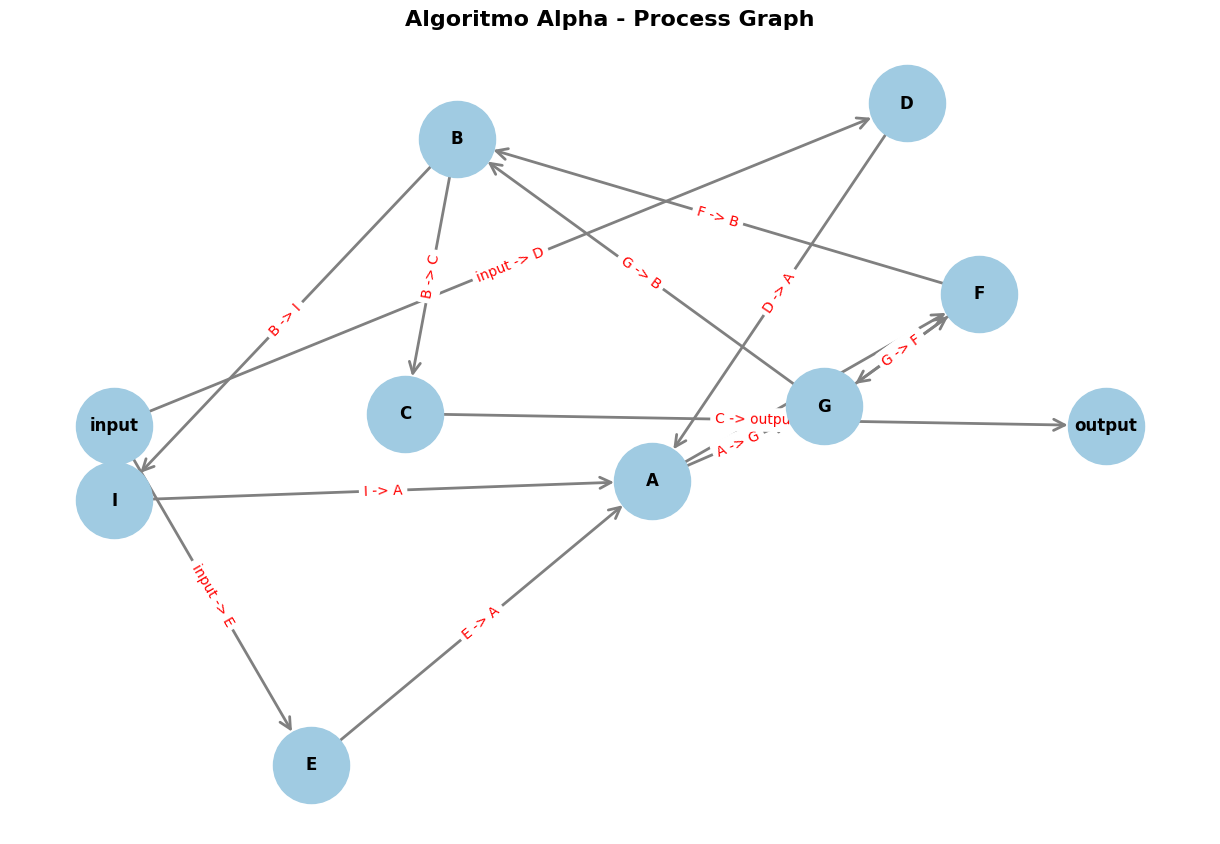

In [31]:
alpha.plot()